Main_Branch Privacy Version

In [37]:
import numpy as np
from tensorflow import keras
from keras.layers import Input, Dense, Lambda, BatchNormalization
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.models import save_model
from keras.models import load_model
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPAdamOptimizer

ImportError: This version of TensorFlow Probability requires TensorFlow version >= 2.14; Detected an installation of version 2.10.0. Please upgrade TensorFlow to proceed.

In [12]:
train_data = pd.read_csv("../data/interim/split/shuffled_train_data_mm.csv", nrows=10000)
test_data = pd.read_csv("../data/interim/split/shuffled_test_data_mm.csv")
val_data = pd.read_csv("../data/interim/split/shuffled_val_data_mm.csv")

In [36]:
target_epsilon = 1.0
target_delta = 1e-5
num_microbatches = 1
gaussian_noise_stddev = target_epsilon * 1.0 / num_microbatches
dp_sum_query = GaussianSumQuery(l2_norm_clip=1.0, stddev=gaussian_noise_stddev)

NameError: name 'GaussianSumQuery' is not defined

In [13]:
train_data_array = train_data.values
test_data_array = test_data.values
val_data_array = val_data.values

In [14]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def get_config(self):
        return {}

    @classmethod
    def from_config(cls, config):
        return cls()

In [15]:
latent_dim = 32
encoder_inputs = Input(shape=(31,), name="input_layer")

n_x1 = 256
x = Dense(n_x1, activation="relu", name="h1")(encoder_inputs)
x = BatchNormalization(name="batch1")(x)
x = Dense(n_x1, activation="relu", name="h2")(x)

# Split x3 into two halves
half_size = n_x1 // 2
x1_first_half = Lambda(lambda x: x[:, :half_size], name="select_z_mean")(x)
x1_second_half = Lambda(lambda x: x[:, half_size:], name="select_z_var")(x)

z_mean = Dense(latent_dim, name="z_mean")(x1_first_half)
z_log_var = Dense(latent_dim, name="z_log_var")(x1_second_half)
z = Sampling(name="Sampling")([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

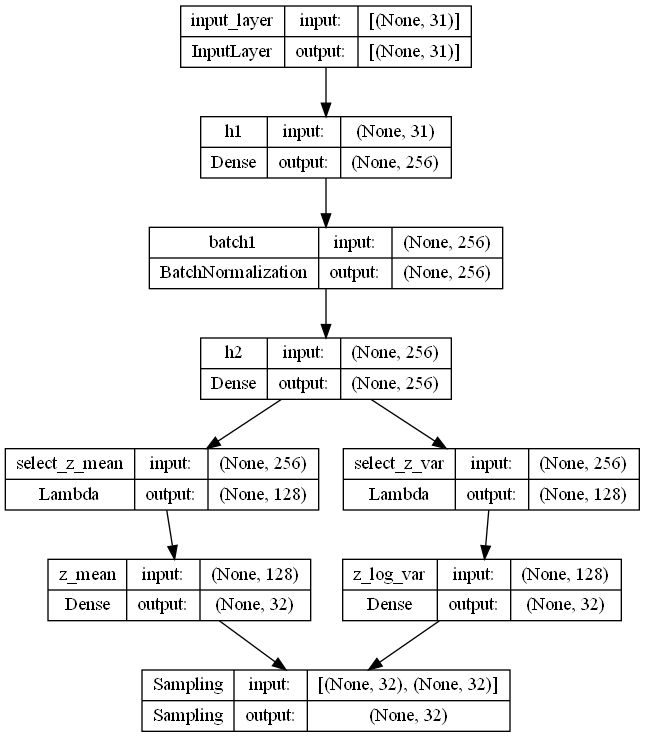

In [16]:
keras.utils.plot_model(encoder, show_shapes=True)

In [17]:
# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
n_x4 = 256
x = Dense(n_x4, activation="relu", name="h4")(latent_inputs)
x = BatchNormalization(name="batch1")(x)
x = Dense(n_x4, activation="relu", name="h5")(x)
cont_decoder_outputs = Dense(30, activation = 'linear', name="cont_decoder_output")(x)
class_decoder_output = Dense(1, activation="sigmoid", name="classification_output")(x)
decoder = keras.Model(latent_inputs, [cont_decoder_outputs, class_decoder_output], name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 h4 (Dense)                     (None, 256)          8448        ['input_1[0][0]']                
                                                                                                  
 batch1 (BatchNormalization)    (None, 256)          1024        ['h4[0][0]']                     
                                                                                                  
 h5 (Dense)                     (None, 256)          65792       ['batch1[0][0]']                 
                                                                                            

In [32]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.reconstruction_loss_class_tracker = keras.metrics.Mean(
            name="reconstruction_loss_class"
        )
        self.mean_abs_diff_cont_tracker = keras.metrics.Mean(name="mean_abs_diff_cont")
        self.mean_abs_diff_class_tracker = keras.metrics.Mean(
            name="mean_abs_diff_class"
        )
        self.mean_binary_tracker = keras.metrics.Mean(name="mean_binary_value")
        self.kl_div_tracker = keras.metrics.Mean(name="kl_divergence")

    def get_config(self):
        config = super(VAE, self).get_config()
        config.update({
            'encoder': self.encoder,
            'decoder': self.decoder,
        })
        return config

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.reconstruction_loss_class_tracker,
        ]

    def call(self, inputs):
        return self.decoder(self.encoder(inputs)[2])

    def train_step(self, data):

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction_cont, reconstruction_class = self.decoder(z)

            data_cont = data[:, :30]
            data_class = data[:, 30:]  # Assuming the last column is for classification

            # Reconstruction loss for continuous outputs
            reconstruction_loss_cont = keras.losses.mean_squared_error(
                data_cont, reconstruction_cont
            )

            # Reconstruction loss for classification output
            reconstruction_loss_class = keras.losses.binary_crossentropy(
                data_class, reconstruction_class
            )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss, axis=1)

            # Compute the KL Div between original data and reconstructed
            kl_div = tf.keras.losses.KLDivergence()(data_cont, reconstruction_cont)

            # Combine losses
            total_loss = (
                reconstruction_loss_cont + reconstruction_loss_class + 0.0001 * kl_loss
            )

        gradients = tape.gradient(total_loss, self.trainable_weights)

        # Add noise to gradients for differential privacy
        optimizer = DPAdamOptimizer(
            l2_norm_clip=1.0,
            noise_multiplier=1.1,
            num_microbatches=1,
            learning_rate=0.001,
        )
        sanitized_gradients, _ = optimizer.compute_gradients(
            total_loss, zip(gradients, self.trainable_variables)
        )

        # Apply sanitized gradients
        self.optimizer.apply_gradients(
            zip(sanitized_gradients, self.trainable_variables)
        )

        # self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss_cont)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reconstruction_loss_class_tracker.update_state(reconstruction_loss_class)
        self.kl_div_tracker.update_state(kl_div)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss_cont": self.reconstruction_loss_tracker.result(),
            "reconstruction_loss_class": self.reconstruction_loss_class_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "sparse_categorical_crossentropy": self.reconstruction_loss_class_tracker.result(),
            "kl_div": self.kl_div_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]  # Unpack the tuple and take the input data

        data_cont = data[
            :, :30
        ]  # Assuming the first 4 columns are for continuous variables
        data_class = data[:, 30:]  # Assuming the last column is for classification

        z_mean, z_log_var, z = self.encoder(data)

        reconstruction_cont, reconstruction_class = self.decoder(z)

        reconstruction_loss_cont = keras.losses.mean_squared_error(
            data_cont, reconstruction_cont
        )

        # Reconstruction loss for classification output
        reconstruction_loss_class = keras.losses.binary_crossentropy(
            data_class, reconstruction_class
        )

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss, axis=1)

        # Combine losses
        total_loss = (
            reconstruction_loss_cont + reconstruction_loss_class + 0.0001 * kl_loss
        )

        # Compute mean absolute differences and mean of binary data
        mean_abs_diff_cont = tf.reduce_mean(tf.abs(data_cont - reconstruction_cont))
        mean_abs_diff_class = tf.reduce_mean(tf.abs(data_class - reconstruction_class))
        mean_binary_value = tf.reduce_mean(
            tf.cast(reconstruction_class >= 0.5, tf.float32)
        )

        # Compute the KL Div between original data and reconstructed
        kl_div = tf.keras.losses.KLDivergence()(data_cont, reconstruction_cont)

        # Update the loss tracker
        self.total_loss_tracker.update_state(total_loss)

        # Update other metrics
        self.reconstruction_loss_tracker.update_state(reconstruction_loss_cont)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reconstruction_loss_class_tracker.update_state(reconstruction_loss_class)
        self.mean_abs_diff_cont_tracker.update_state(mean_abs_diff_cont)
        self.mean_abs_diff_class_tracker.update_state(mean_abs_diff_class)
        self.mean_binary_tracker.update_state(mean_binary_value)
        self.kl_div_tracker.update_state(kl_div)

        # Return a dict mapping metric names to current value
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss_cont": self.reconstruction_loss_tracker.result(),
            "reconstruction_loss_class": self.reconstruction_loss_class_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "mean_abs_diff_cont": self.mean_abs_diff_cont_tracker.result(),
            "mean_abs_diff_class": self.mean_abs_diff_class_tracker.result(),
            "mean_binary_value": self.mean_binary_tracker.result(),
            "kl_div": self.kl_div_tracker.result(),
        }

In [25]:
from tensorflow.python.distribute import estimator_training

In [20]:
from tensorflow_privacy.privacy.optimizers import dp_optimizer

In [26]:
# with this
optimizer = dp_optimizer.DPGradientDescentGaussianOptimizer(
    l2_norm_clip=1, noise_multiplier=0.5, num_microbatches=1, learning_rate = 0.001
)

In [33]:
vae = VAE(encoder, decoder)
vae.compile()

In [34]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitoring validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore weights to the best model observed during training
)

# # Define the directory to save the model
# model_dir = "saved_model/"

# # Define a TensorBoard callback for training logs
# tensorboard_callback = TensorBoard(log_dir="logs/vae_optimized_263")

# # # Define a ModelCheckpoint callback to save the model
# # checkpoint_callback = ModelCheckpoint(
# #     filepath=model_dir, save_best_only=True, monitor="val_loss", mode="min"
# # )
# #tensorboard_callback
call_back_list = [early_stopping_callback]

hist = vae.fit(
    train_data_array,
    epochs=10,
    batch_size=32,
    # validation_data=(val_data_array, None), 
    # callbacks=call_back_list,
)

Epoch 1/10


TypeError: in user code:

    File "c:\Users\Max_G\anaconda3\envs\var_auto\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Max_G\anaconda3\envs\var_auto\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Max_G\anaconda3\envs\var_auto\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Max_G\AppData\Local\Temp\ipykernel_9956\906589092.py", line 74, in train_step
        optimizer = DPAdamOptimizer(

    TypeError: make_optimizer_class.<locals>.DPOptimizerClass.__init__() missing 1 required positional argument: 'dp_sum_query'


In [ ]:
# call_for_saving = vae(train_data_array[:1])

In [ ]:
# vae.save("../models/VAE/optimized_for_data", save_format="tf")

# Synth Data Creation

In [ ]:
# synth Data from Data
generated_data_cont_from_data, generated_data_class_from_data = vae.decoder.predict(
    encoder(train_data_array)[2]
)

313/313 [==============================] - 1s 1ms/step


Saving the synth data from data

In [ ]:
binary_predictions_from_data = (generated_data_class_from_data >= 0.5).astype(int)
print(sum(binary_predictions_from_data))

# Create DataFrame with synthetic data
synthetic_data_from_data = pd.DataFrame(generated_data_cont_from_data, columns=train_data.columns[:-1])
# Add binary_predictions as an additional column
synthetic_data_from_data["Class"] = binary_predictions_from_data
# synthetic_data_from_data.to_csv("../data/interim/privacy_testing/Epoch_100_synthdata_from_data_train_shuffled_for_privacy.csv", index=False)


[13]


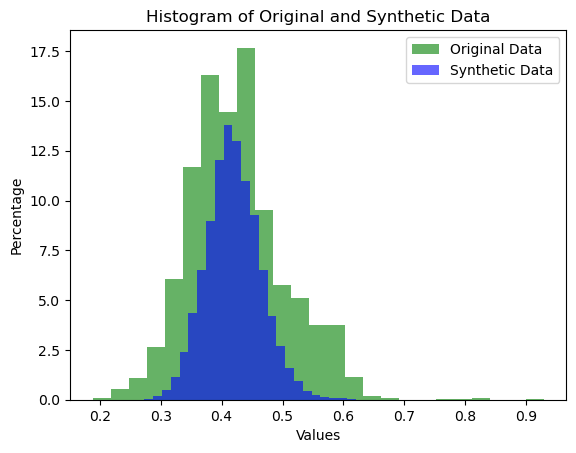

In [ ]:
# Assuming iris_array is the NumPy array you obtained from the Pandas DataFrame
colum_num = 26
original_column = train_data_array[:, colum_num]

synth_column = generated_data_cont_from_data[:, colum_num]

# Calculate the percentage for original_column
total_points_original = len(original_column)
percentage_original = (original_column / total_points_original) * 100

# Calculate the percentage for synth_column
total_points_synth = len(synth_column)
percentage_synth = (synth_column / total_points_synth) * 100

# Plot histograms
plt.hist(
    original_column,
    bins=25,
    color="g",
    alpha=0.6,
    weights=np.ones_like(original_column) / total_points_original * 100,
    label="Original Data",
)

plt.hist(
    synth_column,
    bins=25,
    color="b",
    alpha=0.6,
    weights=np.ones_like(synth_column) / total_points_synth * 100,
    label="Synthetic Data",
)

plt.title("Histogram of Original and Synthetic Data")
plt.xlabel("Values")
plt.ylabel("Percentage")
plt.legend()

plt.show()

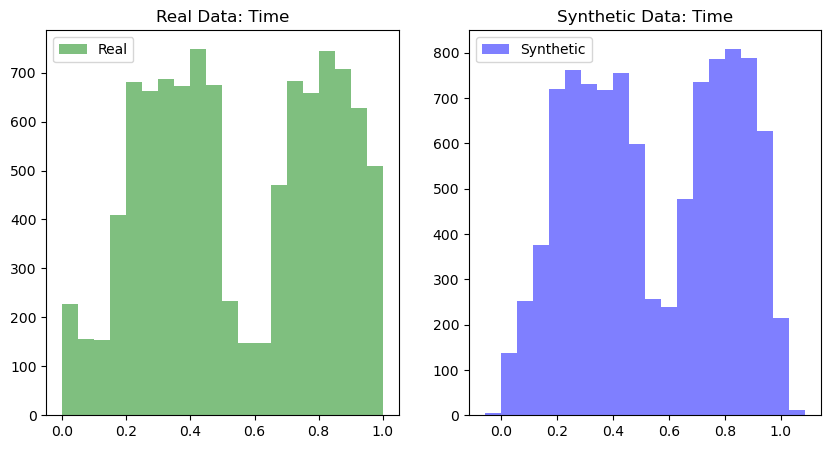

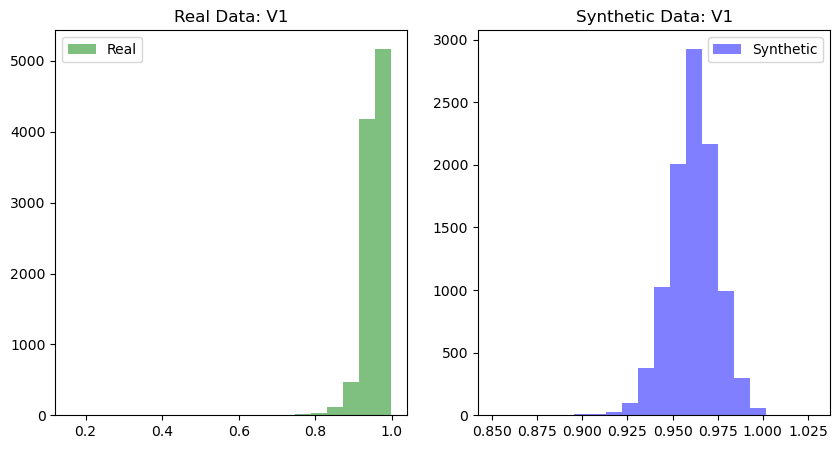

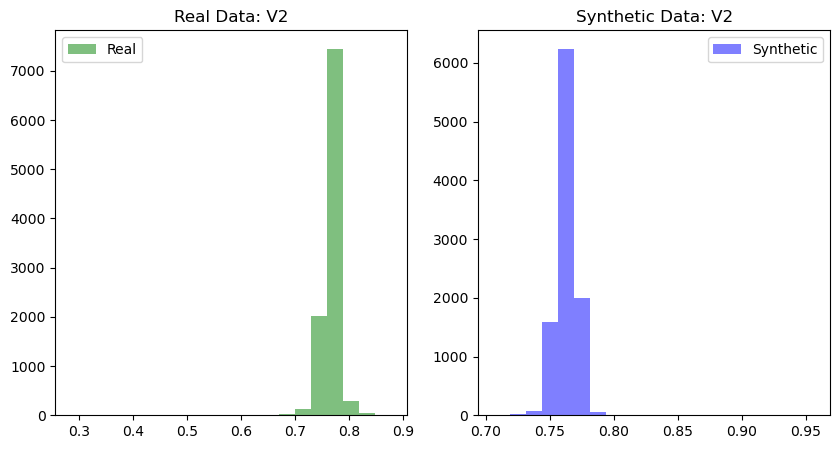

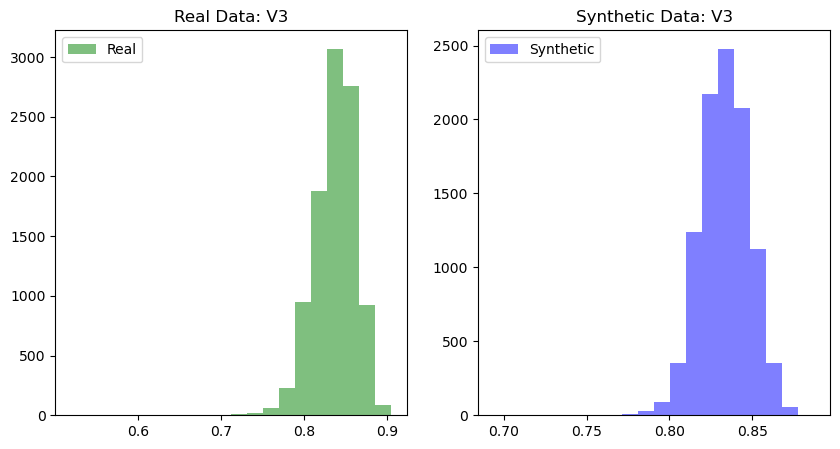

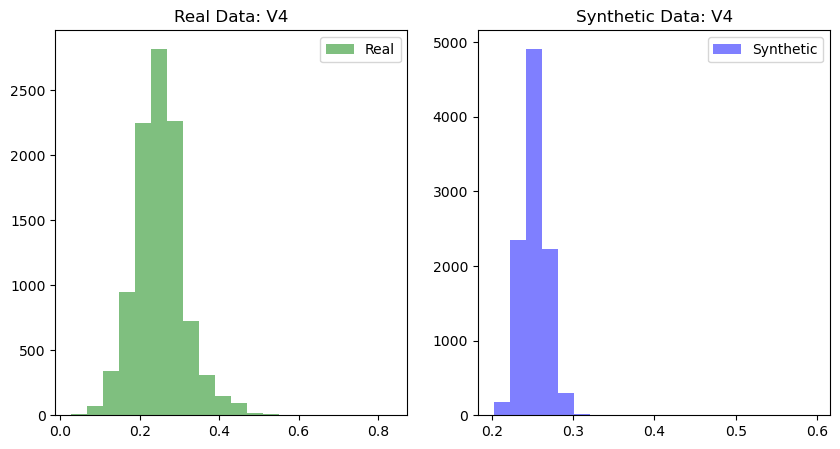

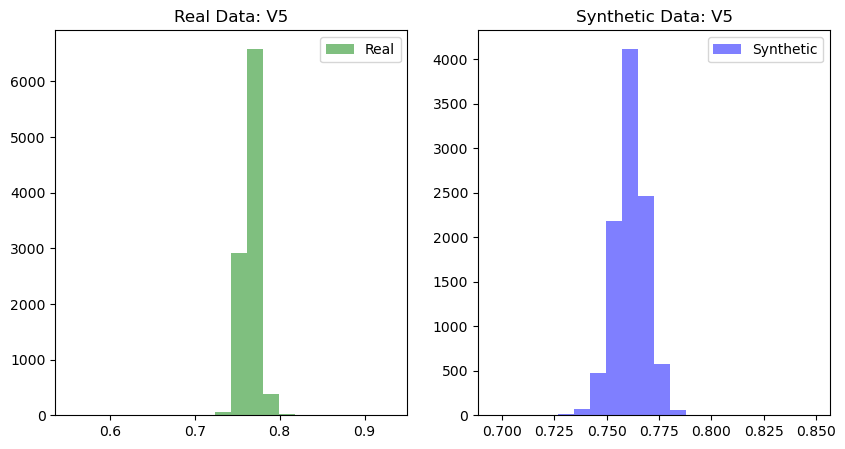

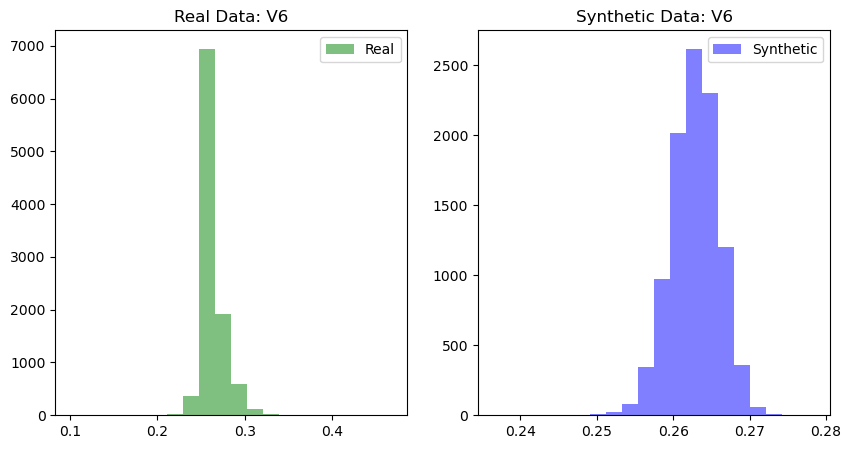

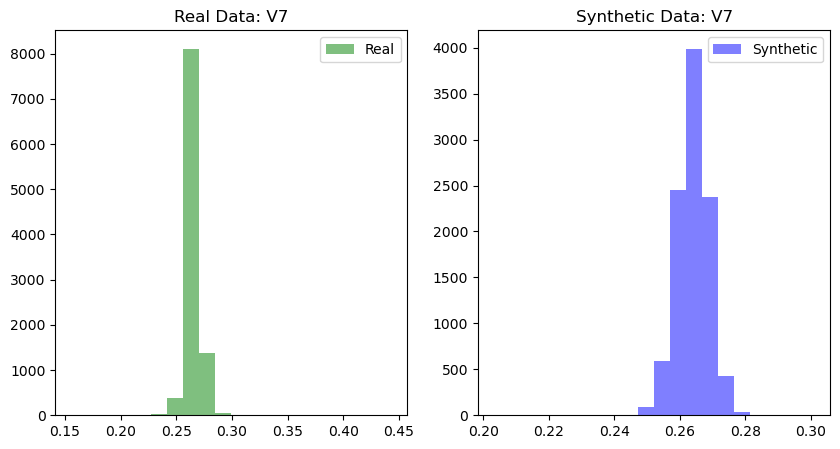

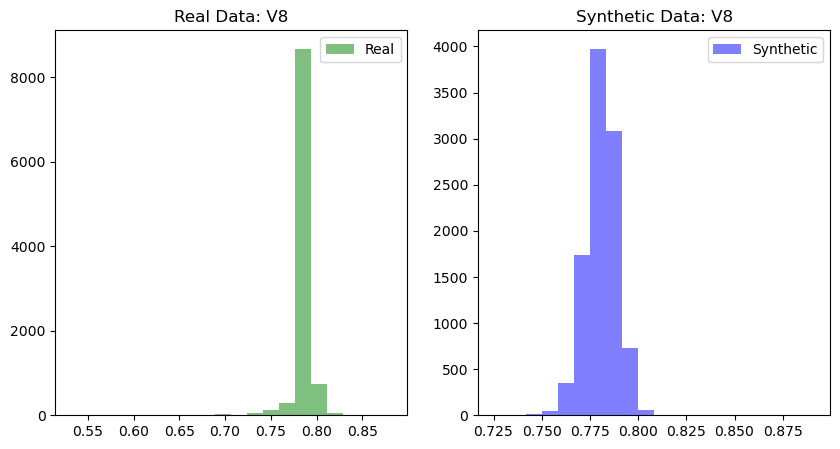

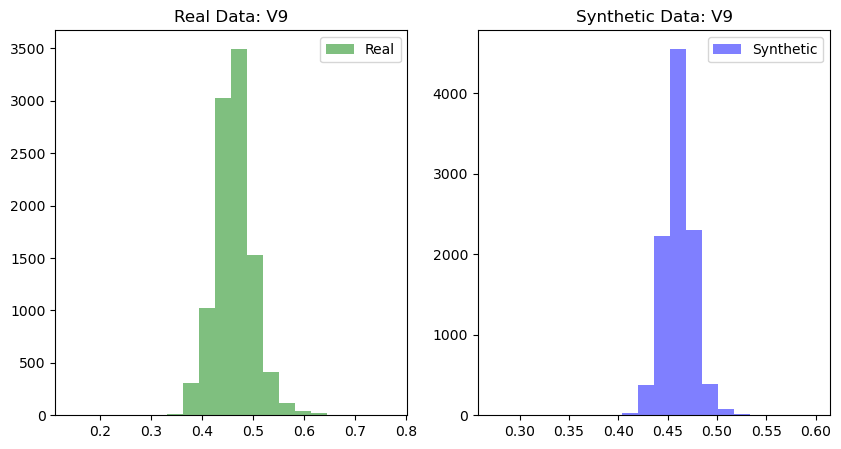

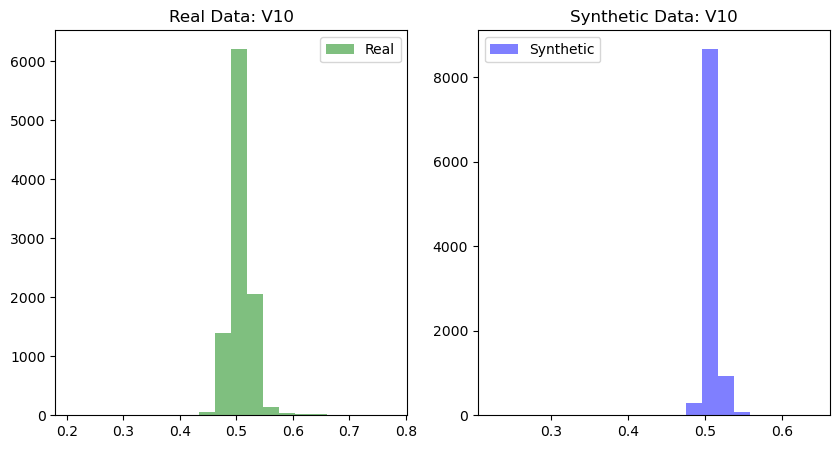

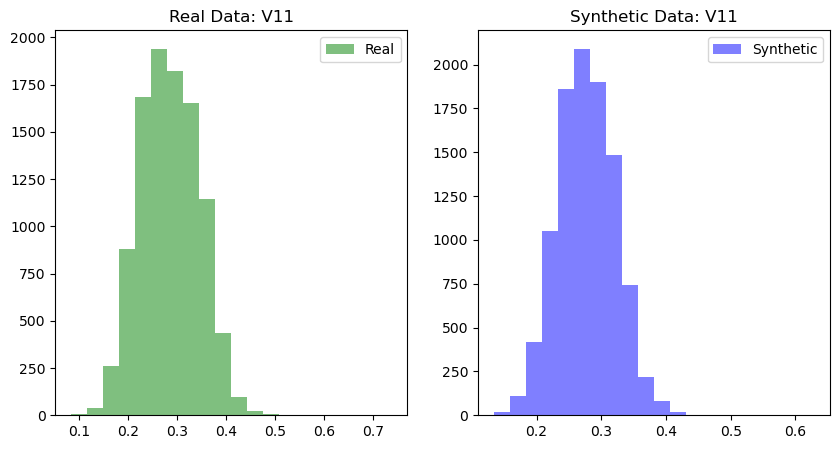

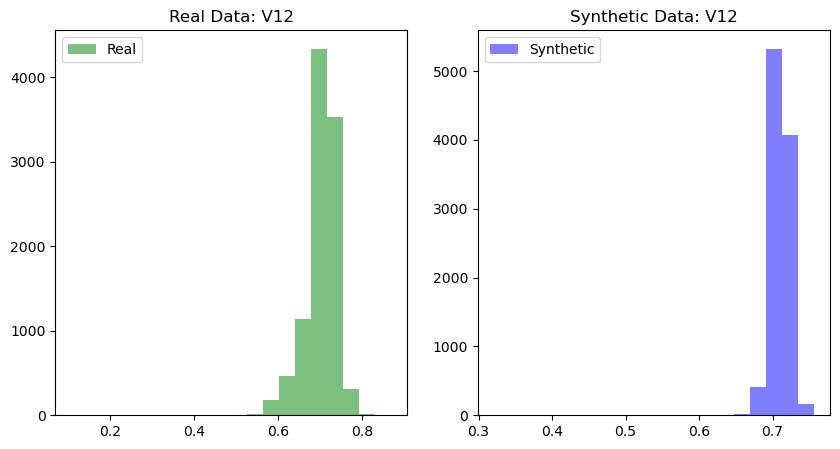

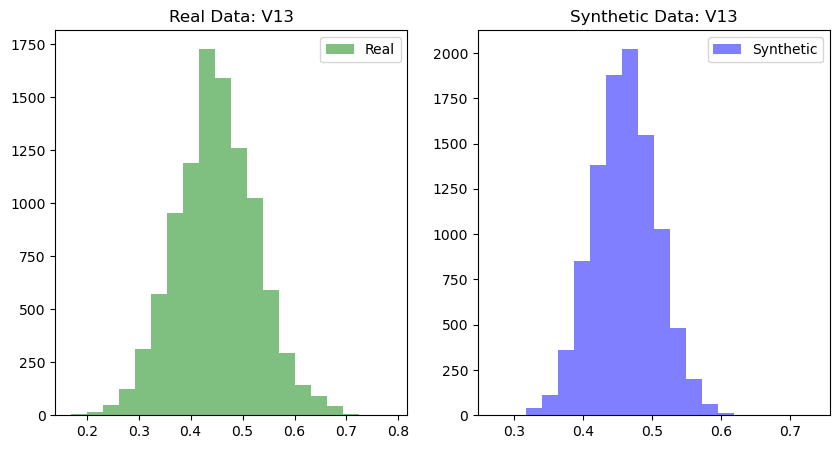

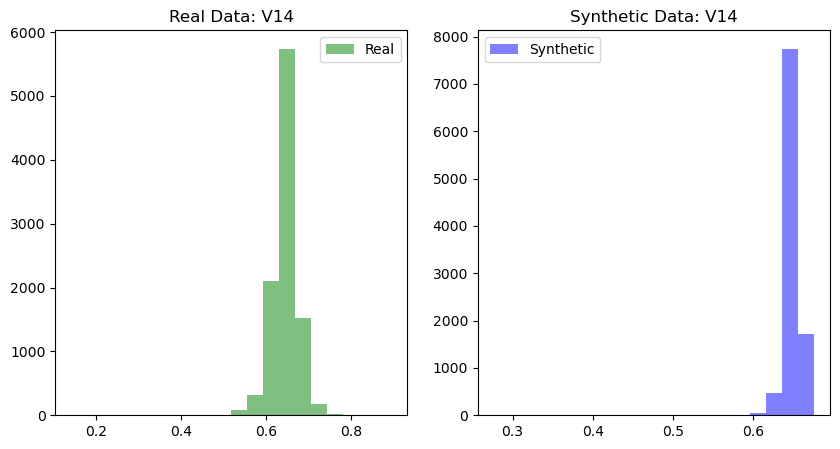

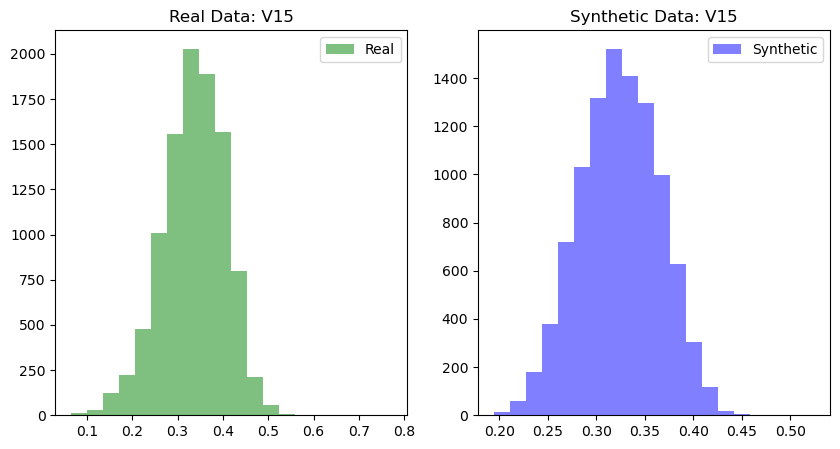

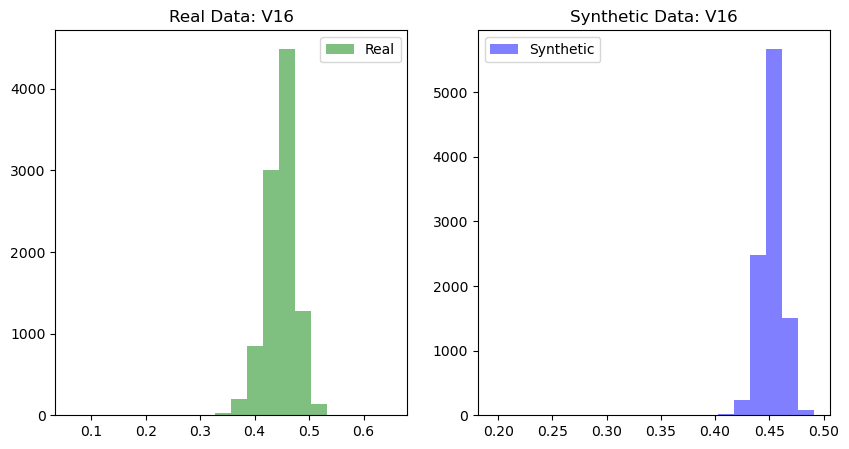

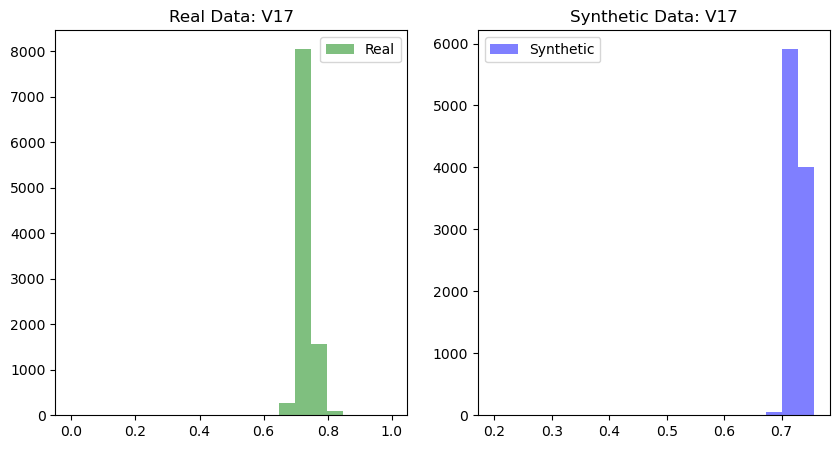

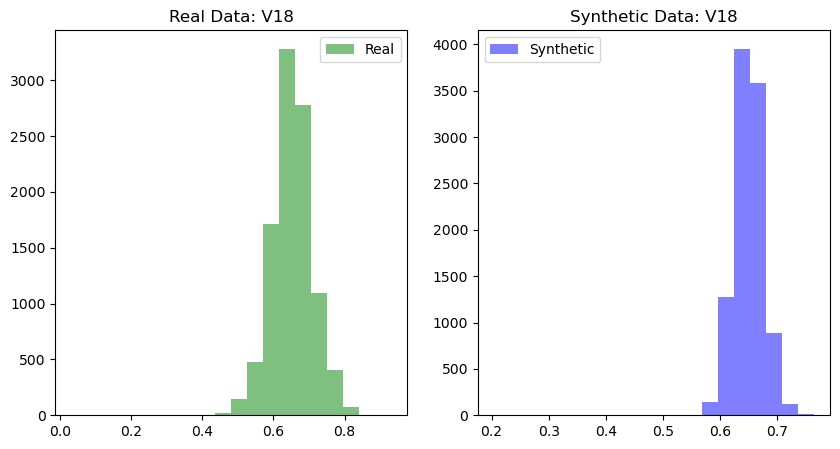

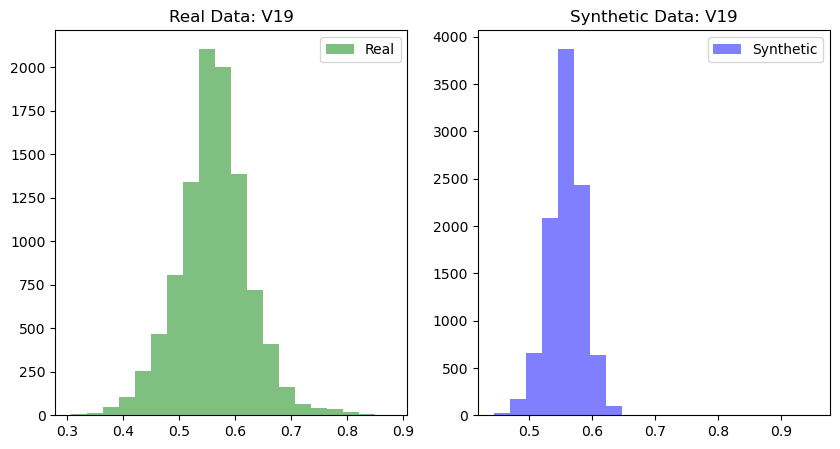

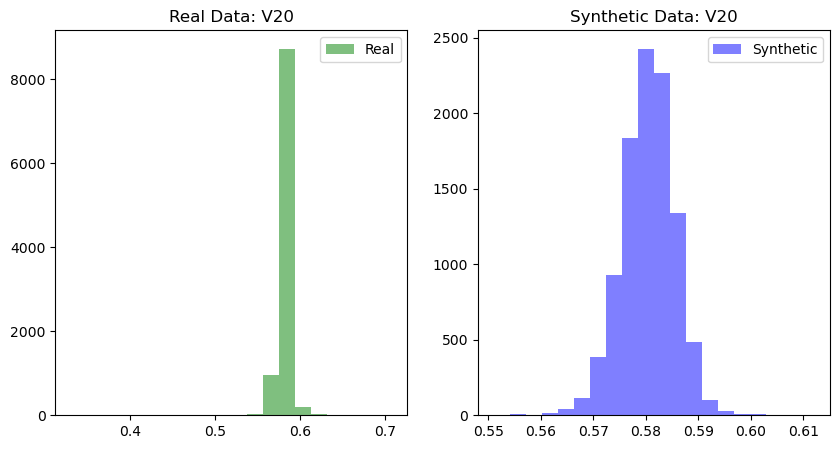

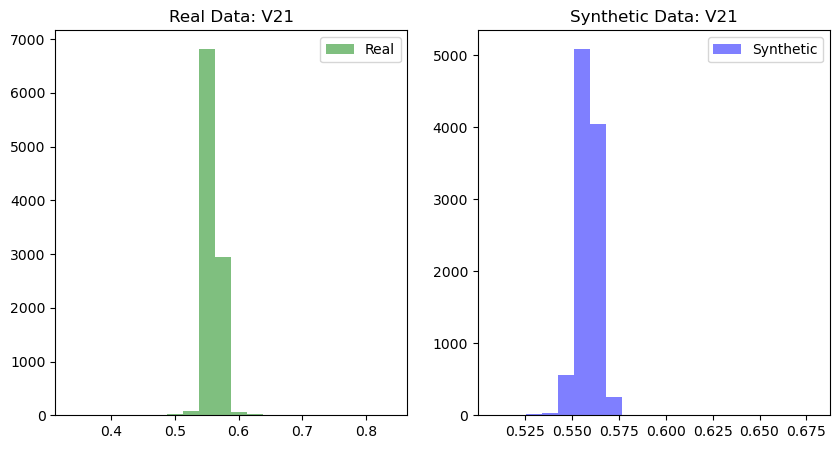

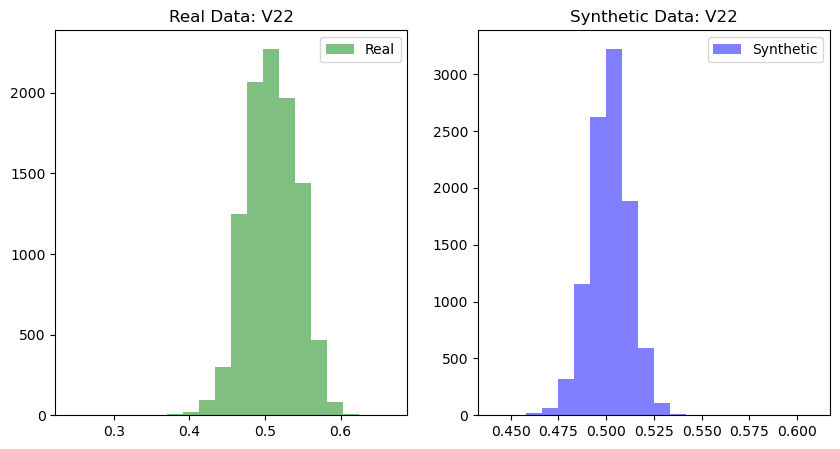

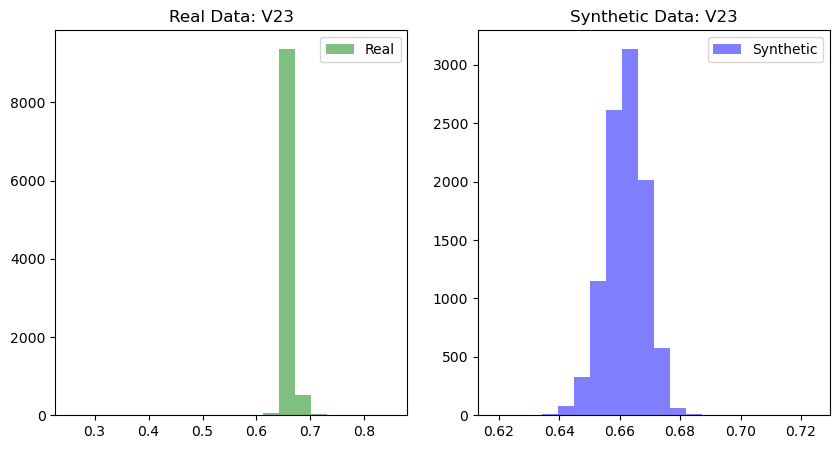

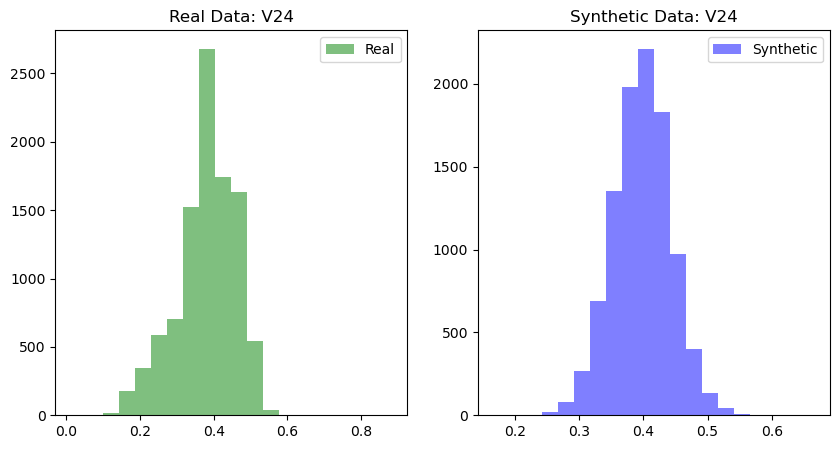

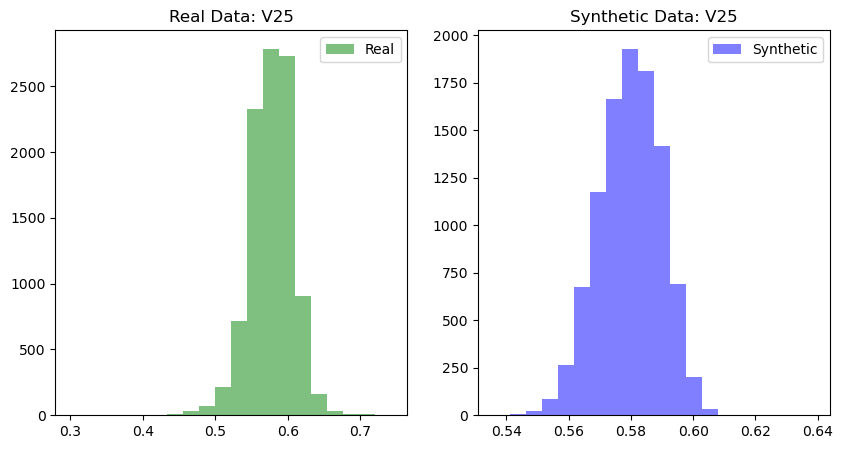

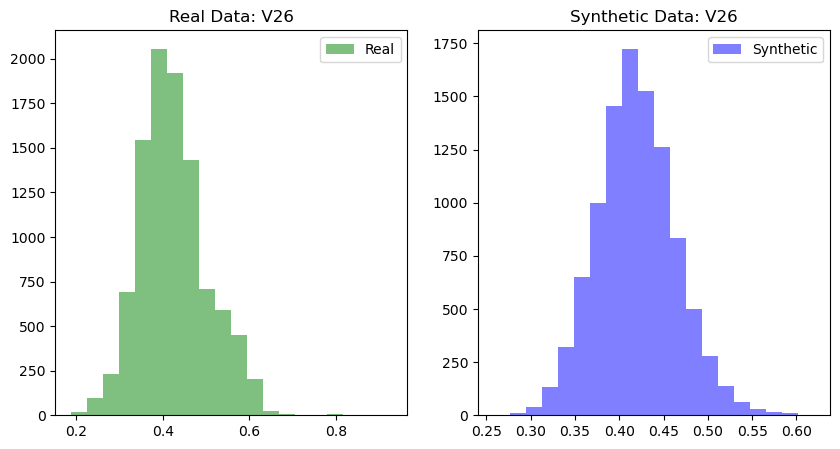

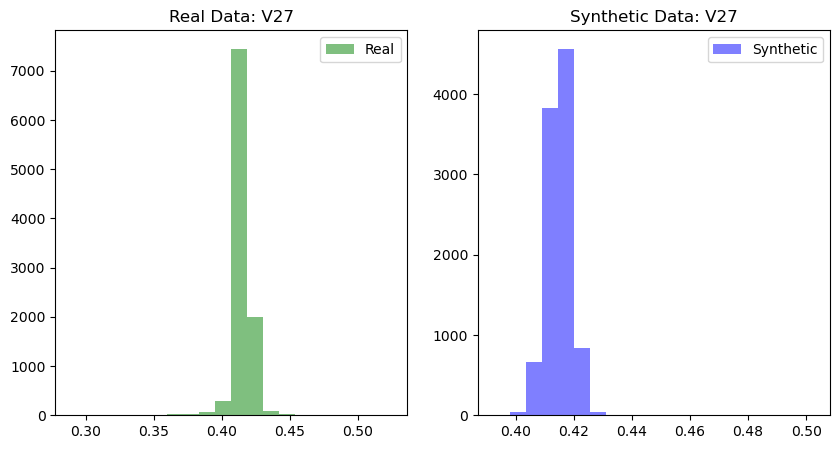

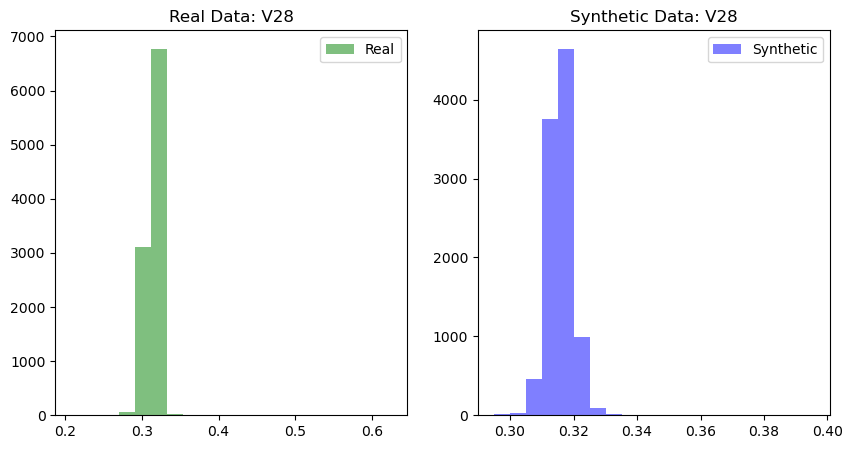

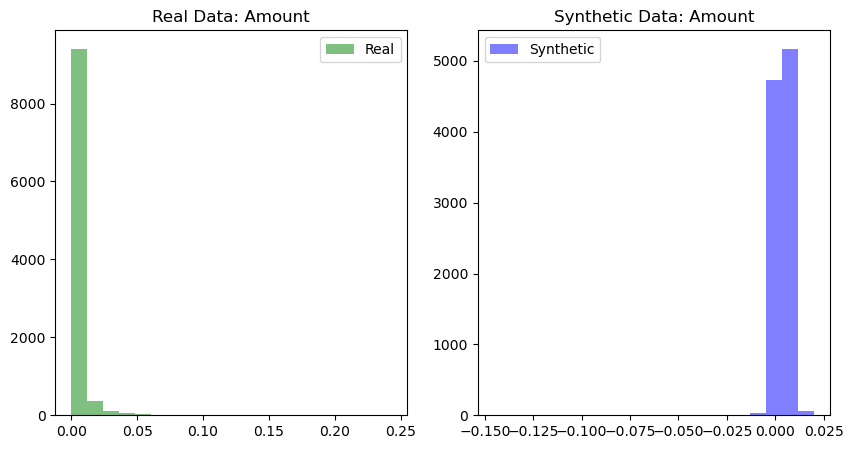

Summary statistics for the real data:
               Time            V1            V2            V3            V4  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.548571      0.958665      0.767310      0.837114      0.251355   
std        0.273956      0.033211      0.017483      0.026152      0.061885   
min        0.000168      0.162285      0.286027      0.519938      0.027126   
25%        0.314155      0.943071      0.761098      0.821563      0.214367   
50%        0.491941      0.959008      0.767870      0.840377      0.251088   
75%        0.805369      0.980864      0.775873      0.854798      0.284085   
max        0.999659      0.999214      0.878483      0.904874      0.833934   

                 V5            V6            V7            V8            V9  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.765778      0.263001      0.265485      0.785140      0.463203   
std        0.

In [ ]:
# For each feature, create a histogram for the real and synthetic data
for feature in train_data.columns[:-1]:

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.hist(train_data[feature], bins=20, alpha=0.5, color="g", label="Real")
    plt.title(f"Real Data: {feature}")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(
        synthetic_data_from_data[feature],
        bins=20,
        alpha=0.5,
        color="b",
        label="Synthetic",
    )
    plt.title(f"Synthetic Data: {feature}")
    plt.legend()

    plt.show()

# Print the summary statistics for the real and synthetic data
print("Summary statistics for the real data:")
print(train_data.describe())
print("\nSummary statistics for the synthetic data:")
print(synthetic_data_from_data.describe())

plt.show()